In [1]:
import sys

# !{sys.executable} -m pip install -r requirements.txt --quiet --upgrade pip

import PIL.Image
from IPython.display import display
from datetime import datetime
from bioclip.predict import Rank
import importlib
import datasets 

import src.bioclip_vector_db.vector_db as vector_db

import importlib

importlib.reload(vector_db)


<module 'src.bioclip_vector_db.vector_db' from '/Users/sreejithnoopur/codebase/bioclip-vector-db/src/bioclip_vector_db/vector_db.py'>

In [2]:
bioclip_vdb = vector_db.BioclipVectorDatabase(vector_db.HfDatasetType.BIRD, 
                                    collection_dir="/tmp/vector_db_bird", 
                                    split="train")

[2025-04-07 12:47:20,164] [INFO] [root] MPS is available
[2025-04-07 12:47:20,375] [INFO] [root] Loaded hf-hub:imageomics/bioclip model config.
[2025-04-07 12:47:21,704] [INFO] [root] Loading pretrained hf-hub:imageomics/bioclip weights (/Users/sreejithnoopur/.cache/huggingface/hub/models--imageomics--bioclip/snapshots/a1a779ecabfa8df4d842e36dafef45a1a4c77a09/open_clip_pytorch_model.bin).
[2025-04-07 12:47:23,651] [INFO] [root] Loading dataset: Somnath01/Birds_Species for split: train


Resolving data files:   0%|          | 0/1000 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/403 [00:00<?, ?it/s]

[2025-04-07 12:47:26,038] [INFO] [root] Dataset loaded with 1000 records.
[2025-04-07 12:47:26,046] [INFO] [chromadb.telemetry.product.posthog] Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.


In [3]:
bioclip_vdb.load_database(reset=True)

[2025-04-07 12:47:34,312] [INFO] [root] Resetting the database.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 153.21images/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 151.77images/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 150.47images/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 156.20images/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 153.54images/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 157.88images/s]

100%|███████████████████

In [4]:
test_dataset = datasets.load_dataset(vector_db.HfDatasetType.BIRD.value, 
                                     split="test", 
                                     streaming=False)

Resolving data files:   0%|          | 0/1000 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/403 [00:00<?, ?it/s]

### Query 

In [6]:
def get_neighbors(test_idx: int):
    query_img_embedding = bioclip_vdb._classifier.create_image_features_for_image(
        test_dataset[test_idx]["image"], normalize=True).tolist()
    
    results = collection.query(query_embeddings=[query_img_embedding], 
                            include = ["metadatas"],
                            n_results = 5)

    return results

In [7]:
def display_neighbors(test_idx: int):
    start_ts = datetime.now()
    neighbors = get_neighbors(test_idx)["ids"][0]
    metadatas =  get_neighbors(test_idx)["metadatas"][0]
    end_ts = datetime.now()
    print("Below is the candidate image")
    display(test_dataset[test_idx]["image"])

    print("\nNearest neighbors")
    for i in range(len(neighbors)):
        print(neighbors[i])
        print(metadatas[i])
        print(bioclip_vdb._dataset[int(neighbors[i])])
        display(bioclip_vdb._dataset[int(neighbors[i])]["image"])

    print(f"Time taken: {end_ts - start_ts}")

Below is the candidate image


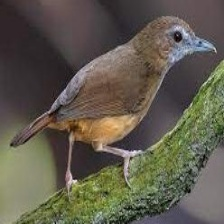


Nearest neighbors
43
{'class': 'Aves', 'common_name': "Abbott's Babbler", 'family': 'Pellorneidae', 'genus': 'Malacocincla', 'kingdom': 'Animalia', 'order': 'Passeriformes', 'phylum': 'Chordata', 'species': 'Malacocincla abbotti', 'species_epithet': 'abbotti'}
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x15FD9E780>, 'label': 0}


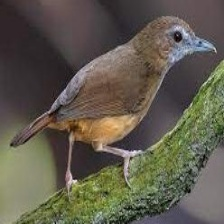

44
{'class': 'Aves', 'common_name': "Abbott's Babbler", 'family': 'Pellorneidae', 'genus': 'Malacocincla', 'kingdom': 'Animalia', 'order': 'Passeriformes', 'phylum': 'Chordata', 'species': 'Malacocincla abbotti', 'species_epithet': 'abbotti'}
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x15FD9E780>, 'label': 0}


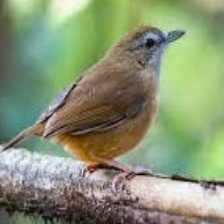

18
{'class': 'Aves', 'common_name': 'White-browed Scrubwren', 'family': 'Acanthizidae', 'genus': 'Sericornis', 'kingdom': 'Animalia', 'order': 'Passeriformes', 'phylum': 'Chordata', 'species': 'Sericornis frontalis', 'species_epithet': 'frontalis'}
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x15FD9E780>, 'label': 0}


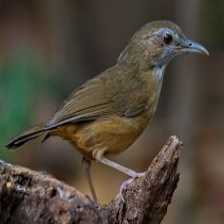

26
{'class': 'Aves', 'common_name': "Abbott's Babbler", 'family': 'Pellorneidae', 'genus': 'Malacocincla', 'kingdom': 'Animalia', 'order': 'Passeriformes', 'phylum': 'Chordata', 'species': 'Malacocincla abbotti', 'species_epithet': 'abbotti'}
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x15FD9E780>, 'label': 0}


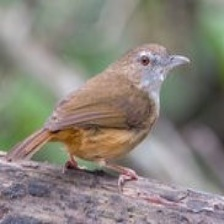

77
{'class': 'Aves', 'common_name': "Abbott's Babbler", 'family': 'Pellorneidae', 'genus': 'Malacocincla', 'kingdom': 'Animalia', 'order': 'Passeriformes', 'phylum': 'Chordata', 'species': 'Malacocincla abbotti', 'species_epithet': 'abbotti'}
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x15FD9E780>, 'label': 0}


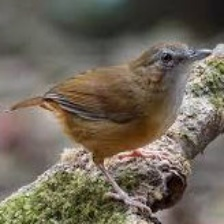

Time taken: 0:00:00.084755


In [11]:
collection = bioclip_vdb.get_vector_database()
display_neighbors(19)